![image](https://www.ewatercycle.org/assets/logo.png)

In [1]:
import logging
logger = logging.getLogger('grpc4bmi.bmi_grpc_client')
logger.setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import numpy as np
from ewatercycle import CFG
import ewatercycle.models
from ewatercycle.forcing import load_foreign
from ewatercycle.models.lisflood import LisfloodParameterSet

## Run lisflood class

The ewatercycle configuration file is typcially stored in `~/.config/.ewatercycle/ewatercycle.yaml` or `/etc/ewatercycle.yaml` and can be imported with `from ewatercycle import CFG`. Relevant settings for lisflood are:

```Yaml
container_engine: singularity # or docker
singularity_dir: '.' # if container_engine is singularity
output_dir: './' # the directory where the model work_dir will be created
```

In [3]:
CFG.load_from_file('./ewatercycle.yaml')

In [4]:
parameterset = LisfloodParameterSet(
    PathRoot='/projects/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked',
    MaskMap='/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD/model_mask.nc',
    config_template='/projects/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml',
)

In [5]:
ewatercycle.models.Lisflood.available_versions

['20.10']

In [6]:
# lisflood_ERA-Interim_*_1990_1990.nc data can be copied 
# from /projects/0/wtrcycle/comparison/forcing/lisflood
# also the forcing_dir should include the lisvap output files
forcing = load_foreign(target_model='lisflood',
                     directory='/scratch/shared/ewatercycle/lisflood_forcing_data/',
                     start_time='1990-01-01T00:00:00Z',
                     end_time='1990-12-31T00:00:00Z',
                     forcing_info={
                         'PrefixPrecipitation': 'lisflood_ERA-Interim_pr_1990_1990.nc',
                         'PrefixTavg': 'lisflood_ERA-Interim_tas_1990_1990.nc',
                         'PrefixE0': 'lisflood_e0_1990_1990.nc',
                         'PrefixES0': 'lisflood_es0_1990_1990.nc',
                         'PrefixET0': 'lisflood_et0_1990_1990.nc',
                     })
forcing

LisfloodForcing(start_time='1990-01-01T00:00:00Z', end_time='1990-12-31T00:00:00Z', directory='/scratch/shared/ewatercycle/lisflood_forcing_data/', shape=None, PrefixPrecipitation='lisflood_ERA-Interim_pr_1990_1990.nc', PrefixTavg='lisflood_ERA-Interim_tas_1990_1990.nc', PrefixE0='lisflood_e0_1990_1990.nc', PrefixES0='lisflood_es0_1990_1990.nc', PrefixET0='lisflood_et0_1990_1990.nc')

In [7]:
# create lisflood instance
model = ewatercycle.models.Lisflood(version='20.10', parameter_set=parameterset, forcing=forcing)
model

In [8]:
model.parameters

[('IrrigationEfficiency', '0.75'),
 ('PathRoot',
  '/lustre1/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked'),
 ('MaskMap',
  '/lustre1/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD'),
 ('config_template',
  '/lustre1/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml'),
 ('start_time', '1990-01-01T00:00:00Z'),
 ('end_time', '1990-12-31T00:00:00Z'),
 ('forcing directory', '/scratch/shared/ewatercycle/lisflood_forcing_data')]

In [9]:
# setup model
config_file, config_dir = model.setup(IrrigationEfficiency='0.8', end_time='1990-10-10T00:00:00Z')

Running /nfs/home2/fakhereh/temp/lisflood_run/ewatercycle-lisflood-grpc4bmi_20.10.sif singularity container on port 42559


In [10]:
print(config_file)
print(config_dir)
model.parameters

/scratch/shared/ewatercycle/lisflood_20210621_164834/lisflood_setting.xml
/scratch/shared/ewatercycle/lisflood_20210621_164834


[('IrrigationEfficiency', '0.8'),
 ('PathRoot',
  '/lustre1/0/wtrcycle/comparison/lisflood_input/Lisflood01degree_masked'),
 ('MaskMap',
  '/lustre1/0/wtrcycle/comparison/recipes_auxiliary_datasets/LISFLOOD'),
 ('config_template',
  '/lustre1/0/wtrcycle/comparison/lisflood_input/settings_templates/settings_lisflood.xml'),
 ('start_time', '1990-01-01T00:00:00Z'),
 ('end_time', '1990-10-10T00:00:00Z'),
 ('forcing directory', '/scratch/shared/ewatercycle/lisflood_forcing_data')]

In [11]:
# get metadata
print(model.output_var_names)

('Discharge',)


In [12]:
# initialize
model.initialize(str(config_file))

In [13]:
# run model with bmi
model.update()

In [14]:
# get value
discharge = model.get_value('Discharge')

In [15]:
np.count_nonzero(~np.isnan(discharge))

3060

In [16]:
discharge = model.get_value_as_xarray('Discharge')

In [17]:
discharge

<xarray.DataArray 'Discharge' (latitude: 1500, longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float64 89.95 89.85 89.75 ... -59.75 -59.85 -59.95
    time       object 1990-01-03 00:00:00
Attributes:
    units:    m^3/s

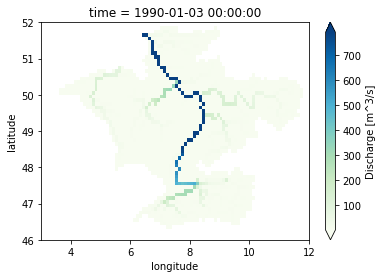

In [18]:
lc = discharge.coords["longitude"]
la = discharge.coords["latitude"]
discharge.loc[
    dict(longitude=lc[(lc > 3) & (lc < 12)], latitude=la[(la > 46) & (la < 52)])].plot(robust=True, cmap='GnBu')

In [19]:
# get value at coordinates
model.get_value_at_coords('Discharge', lon=[-71.35], lat=[42.64])

array([9.10970681])

In [21]:
# coords to indices
model._coords_to_indices('Discharge',  lon=[-71.35, 5.6], lat=[42.65, 50.7])

(array([1703886, 1413056]), array([-71.35,   5.65]), array([42.65, 50.75]))

In [22]:
# stop the model
del model.bmi